In [1]:
import matplotlib.pyplot as plt
from os.path import exists
import os
import pandas as pd    
import numpy as np    
import seaborn as sns  
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.model_selection import GridSearchCV
from keras.callbacks import ModelCheckpoint
import matplotlib.dates as mdates
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.losses as loss

2024-01-02 07:41:27.153560: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-02 07:41:27.185311: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-02 07:41:27.185348: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-02 07:41:27.186557: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-02 07:41:27.192418: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-02 07:41:27.193351: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
data = pd.read_csv("PdM_telemetry.csv")
errors = pd.read_csv("PdM_errors.csv")
maintenances = pd.read_csv("PdM_maint.csv")
failures = pd.read_csv("PdM_failures.csv")
machines = pd.read_csv("PdM_machines.csv")

In [3]:
print(machines.count())

machineID    100
model        100
age          100
dtype: int64


In [4]:
print(errors.count())

datetime     3919
machineID    3919
errorID      3919
dtype: int64


In [5]:
print(maintenances.count())

datetime     3286
machineID    3286
comp         3286
dtype: int64


In [6]:
sel_fail = failures.loc[failures['machineID'] == 11]
sel_err = errors.loc[errors['machineID'] == 11]

In [7]:
y_category = list()

for iter in range(0, len(sel_fail)):
  y_category.append('Failure')

for iter in range(0, len(sel_err)):
  y_category.append('Error')

In [8]:
df_timestamp = pd.concat([sel_fail['datetime'], sel_err['datetime']], ignore_index=True, axis=0)
df_plot = pd.DataFrame({"timestamp": df_timestamp, "category": y_category})
df_plot.loc[:, 'timestamp'] = pd.to_datetime(df_plot.loc[:, 'timestamp'])
df_plot.sort_values(by=['timestamp'], inplace=True, ignore_index=True)

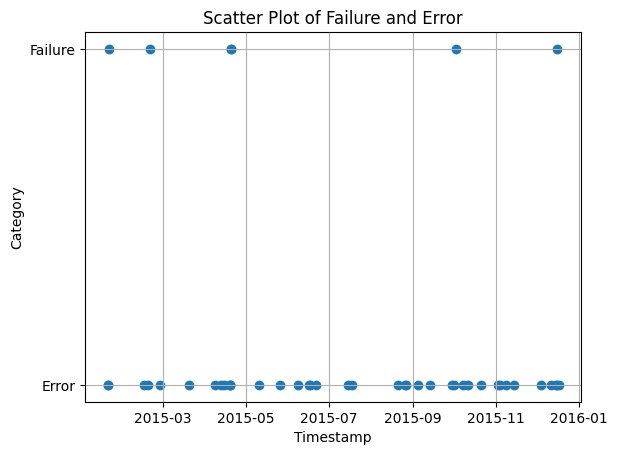

In [9]:
plt.scatter(df_plot['timestamp'], df_plot['category'])

# Configure the plot
plt.xlabel('Timestamp')
plt.ylabel('Category')
plt.title('Scatter Plot of Failure and Error')
plt.grid(True)

# Show the plot
plt.show()

#### Preporcessing Datasets

#### Failures

In [10]:
failures.loc[failures.failure == "comp1","failure"] = "failComp1"
failures.loc[failures.failure == "comp2","failure"] = "failComp2"
failures.loc[failures.failure == "comp3","failure"] = "failComp3"
failures.loc[failures.failure == "comp4","failure"] = "failComp4"

In [11]:
one_hot = pd.get_dummies(failures['failure'])
failures = failures.join(one_hot)
failures = failures.drop('failure',axis=1)
failures['datetime'] = failures['datetime'].apply(pd.to_datetime)

#### Errors

In [12]:
one_hot = pd.get_dummies(errors['errorID'])
errors = errors.join(one_hot)
errors = errors.drop('errorID',axis=1)
errors['datetime'] = errors['datetime'].apply(pd.to_datetime)

#### Machines

In [13]:
machines = machines.drop('model',axis=1)

#### Maintainaces

In [14]:
maintenances.loc[maintenances.comp == "comp1", "comp"] = "maintComp1"
maintenances.loc[maintenances.comp == "comp2", "comp"] = "maintComp2"
maintenances.loc[maintenances.comp == "comp3", "comp"] = "maintComp3"
maintenances.loc[maintenances.comp == "comp4", "comp"] = "maintComp4"

In [15]:
one_hot = pd.get_dummies(maintenances['comp'])
maintenances = maintenances.join(one_hot)
maintenances = maintenances.drop('comp',axis=1)
maintenances['datetime'] = maintenances['datetime'].apply(pd.to_datetime)

In [16]:
data

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511
...,...,...,...,...,...,...
876095,2016-01-01 02:00:00,100,179.438162,395.222827,102.290715,50.771941
876096,2016-01-01 03:00:00,100,189.617555,446.207972,98.180607,35.123072
876097,2016-01-01 04:00:00,100,192.483414,447.816524,94.132837,48.314561
876098,2016-01-01 05:00:00,100,165.475310,413.771670,104.081073,44.835259


#### Data

In [17]:
data['datetime'] = pd.to_datetime(data['datetime'])

In [18]:
FinalDF = pd.merge(data,machines,on=['machineID'])
FinalDF = pd.merge(FinalDF,errors,how = 'left' , on=['datetime','machineID'])
FinalDF = pd.merge(FinalDF,maintenances,how = 'left' , on=['datetime','machineID'])
FinalDF = pd.merge(FinalDF,failures,how = 'left' , on=['datetime','machineID'])
FinalDF.fillna(0)

,datetime,machineID,volt,rotate,pressure,vibration,age,error1,error2,error3,error4,error5,maintComp1,maintComp2,maintComp3,maintComp4,failComp1,failComp2,failComp3,failComp4
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,18,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,18,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,18,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,18,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,18,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
877204,2016-01-01 02:00:00,100,179.438162,395.222827,102.290715,50.771941,5,0,0,0,0,0,0,0,0,0,0,0,0,0
877205,2016-01-01 03:00:00,100,189.617555,446.207972,98.180607,35.123072,5,0,0,0,0,0,0,0,0,0,0,0,0,0
877206,2016-01-01 04:00:00,100,192.483414,447.816524,94.132837,48.314561,5,0,0,0,0,0,0,0,0,0,0,0,0,0
877207,2016-01-01 05:00:00,100,165.475310,413.771670,104.081073,44.835259,5,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Creating Datasets

In [19]:
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i, 0:dataset.shape[1]])
    return np.array(dataX),np.array(dataY)

In [20]:
def data_per_machine(x):
    data_machine_x = Dataset_LTSM[Dataset_LTSM["machineID"] == x]
    data_machine_x =data_machine_x.drop(['machineID'], axis=1)
    scaler = MinMaxScaler(feature_range=(0,1))
    data1_new_for_training_scaled = scaler.fit_transform(data_machine_x )
    return createXY(data1_new_for_training_scaled,5) 

#### Base Model

In [21]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model=Sequential()
model.add(LSTM(15,activation='tanh', return_sequences=True ,input_shape=(5,4)))
model.add(LSTM(10,activation='tanh' ))

model.add(Dropout(0.2))
model.add(Dense(4))


#Model summary
model.summary()

#Compiling
model.compile(optimizer=opt, loss = "mse")
tf.keras.utils.plot_model(model,  show_shapes=True,  show_layer_names=False)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 15)             1200      
                                                                 
 lstm_1 (LSTM)               (None, 10)                1040      
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense (Dense)               (None, 4)                 44        
                                                                 
Total params: 2284 (8.92 KB)
Trainable params: 2284 (8.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [22]:
Dataset_LTSM = FinalDF[[ "machineID","volt","rotate","pressure","vibration"]]

In [23]:
Results = pd.DataFrame()

for i in range(1, 50):
    print("Iteration #", i)
    
    # Assuming data_per_machine(i) returns the training data for the i-th machine
    trainX, trainY = data_per_machine(i)
    
    # Training the model using the training data
    history = model.fit(trainX, trainY, epochs=100, batch_size=100, validation_split=0.2, verbose=0)
    
    # Storing the training loss values into the Results DataFrame
    Results["Machine", i] = history.history["loss"]

Iteration # 1
Iteration # 2
Iteration # 3
Iteration # 4
Iteration # 5
Iteration # 6
Iteration # 7
Iteration # 8
Iteration # 9
Iteration # 10
Iteration # 11
Iteration # 12
Iteration # 13
Iteration # 14
Iteration # 15
Iteration # 16
Iteration # 17
Iteration # 18
Iteration # 19
Iteration # 20
Iteration # 21
Iteration # 22
Iteration # 23
Iteration # 24
Iteration # 25
Iteration # 26
Iteration # 27
Iteration # 28
Iteration # 29
Iteration # 30
Iteration # 31
Iteration # 32
Iteration # 33
Iteration # 34
Iteration # 35
Iteration # 36
Iteration # 37
Iteration # 38
Iteration # 39
Iteration # 40
Iteration # 41
Iteration # 42
Iteration # 43
Iteration # 44
Iteration # 45
Iteration # 46
Iteration # 47
Iteration # 48
Iteration # 49


274/274 [==============================] - 1s 1ms/step


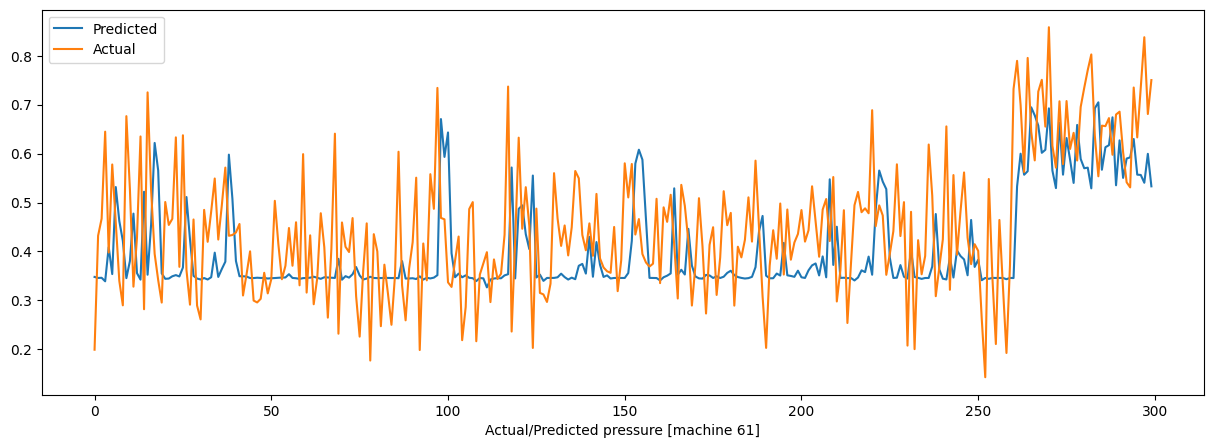

In [24]:
testX,testY= data_per_machine(61)
y_pred=model.predict(testX)

plt.figure(figsize=(15 , 5))
plt.plot(y_pred[:300,2],label='Predicted')
plt.plot(testY[:300,2],label='Actual')
plt.xlabel("Actual/Predicted pressure [machine 61]")
plt.legend()
plt.show()

274/274 [==============================] - 0s 1ms/step


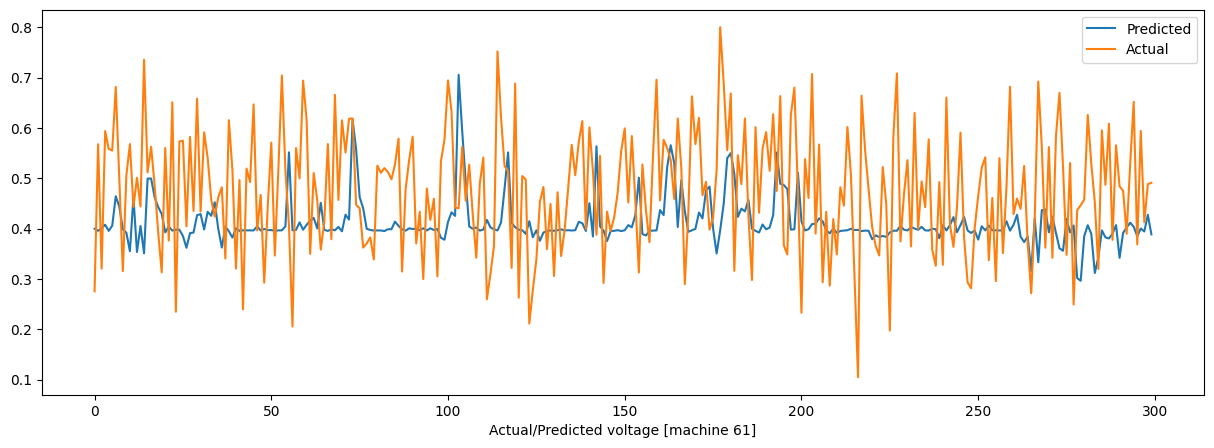

In [25]:
testX,testY= data_per_machine(61)
y_pred=model.predict(testX)

plt.figure(figsize=(15 , 5))
plt.plot(y_pred[:300,3],label='Predicted')
plt.plot(testY[:300,3],label='Actual')
plt.xlabel("Actual/Predicted voltage [machine 61]")
plt.legend()
plt.show()

274/274 [==============================] - 0s 1ms/step


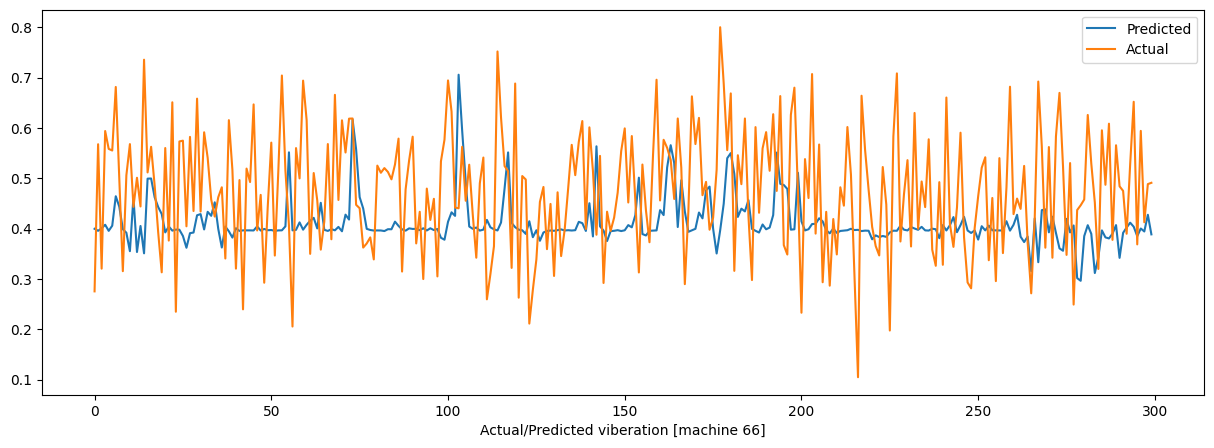

In [26]:
testX,testY= data_per_machine(61)
y_pred=model.predict(testX)

plt.figure(figsize=(15 , 5))
plt.plot(y_pred[:300,3],label='Predicted')
plt.plot(testY[:300,3],label='Actual')
plt.xlabel("Actual/Predicted viberation [machine 66]")
plt.legend()
plt.show()

In [27]:
model.save("LSTM-50machines.h5")

/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [28]:
Results

,"(Machine, 1)","(Machine, 2)","(Machine, 3)","(Machine, 4)","(Machine, 5)","(Machine, 6)","(Machine, 7)","(Machine, 8)","(Machine, 9)","(Machine, 10)",...,"(Machine, 40)","(Machine, 41)","(Machine, 42)","(Machine, 43)","(Machine, 44)","(Machine, 45)","(Machine, 46)","(Machine, 47)","(Machine, 48)","(Machine, 49)"
0,0.134401,0.015216,0.014493,0.012097,0.014903,0.014987,0.015908,0.014592,0.014888,0.013900,...,0.015230,0.013311,0.013683,0.013061,0.015329,0.014044,0.016107,0.014523,0.014707,0.013630
1,0.041083,0.015076,0.014267,0.011795,0.014309,0.014659,0.015457,0.014483,0.014745,0.013784,...,0.014915,0.012875,0.013217,0.012786,0.014558,0.013078,0.015316,0.014318,0.014470,0.013224
2,0.030411,0.015094,0.014282,0.011764,0.014280,0.014635,0.015384,0.014487,0.014715,0.013806,...,0.014870,0.012811,0.013200,0.012757,0.014504,0.013054,0.015198,0.014200,0.014426,0.013161
3,0.025016,0.015059,0.014255,0.011761,0.014262,0.014624,0.015401,0.014435,0.014646,0.013742,...,0.014807,0.012833,0.013156,0.012744,0.014475,0.012987,0.015158,0.014231,0.014406,0.013140
4,0.022533,0.015040,0.014229,0.011759,0.014264,0.014603,0.015394,0.014437,0.014670,0.013764,...,0.014787,0.012791,0.013182,0.012717,0.014425,0.013020,0.015131,0.014177,0.014428,0.013108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.014069,0.014745,0.014131,0.011660,0.014166,0.014431,0.015232,0.014276,0.014442,0.013558,...,0.014439,0.012552,0.012858,0.012428,0.014154,0.012679,0.014762,0.013890,0.014055,0.012747
96,0.014040,0.014738,0.014131,0.011682,0.014120,0.014431,0.015199,0.014298,0.014436,0.013599,...,0.014464,0.012556,0.012853,0.012380,0.014165,0.012655,0.014802,0.013907,0.014015,0.012757
97,0.014061,0.014717,0.014133,0.011649,0.014169,0.014413,0.015170,0.014320,0.014413,0.013566,...,0.014421,0.012574,0.012865,0.012392,0.014161,0.012726,0.014791,0.013891,0.014024,0.012712
98,0.014025,0.014733,0.014121,0.011684,0.014126,0.014438,0.015179,0.014305,0.014451,0.013574,...,0.014480,0.012554,0.012858,0.012374,0.014160,0.012701,0.014763,0.013902,0.014013,0.012726


In [29]:
FinalDF_v1=FinalDF[["volt" ,"rotate" ,"pressure","vibration" ,"failComp1" ,"failComp2","failComp3","failComp4"]]
FinalDF_v1["Fail_n"]=0

def categorise(row):  
    if row['failComp1'] == 1:
        return 1
    elif row['failComp2'] == 1:
        return 2
    elif row['failComp3'] == 1:
        return 3
    elif row['failComp4'] == 1:
        return 4
    return 0
FinalDF_v1['Fail_n'] = FinalDF_v1.apply(lambda FinalDF_v1: categorise(FinalDF_v1), axis=1)
FinalDF_v1

/tmp/ipykernel_106348/2589465373.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FinalDF_v1["Fail_n"]=0


/tmp/ipykernel_106348/2589465373.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FinalDF_v1['Fail_n'] = FinalDF_v1.apply(lambda FinalDF_v1: categorise(FinalDF_v1), axis=1)


,volt,rotate,pressure,vibration,failComp1,failComp2,failComp3,failComp4,Fail_n
0,176.217853,418.504078,113.077935,45.087686,NaN,NaN,NaN,NaN,0
1,162.879223,402.747490,95.460525,43.413973,NaN,NaN,NaN,NaN,0
2,170.989902,527.349825,75.237905,34.178847,NaN,NaN,NaN,NaN,0
3,162.462833,346.149335,109.248561,41.122144,NaN,NaN,NaN,NaN,0
4,157.610021,435.376873,111.886648,25.990511,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...
877204,179.438162,395.222827,102.290715,50.771941,NaN,NaN,NaN,NaN,0
877205,189.617555,446.207972,98.180607,35.123072,NaN,NaN,NaN,NaN,0
877206,192.483414,447.816524,94.132837,48.314561,NaN,NaN,NaN,NaN,0
877207,165.475310,413.771670,104.081073,44.835259,NaN,NaN,NaN,NaN,0


In [30]:
# Concatenate DataFrames to create NewDF
NewDF = pd.concat([
    FinalDF_v1[FinalDF_v1["Fail_n"] == 1],
    FinalDF_v1[FinalDF_v1["Fail_n"] == 2],
    FinalDF_v1[FinalDF_v1["Fail_n"] == 3],
    FinalDF_v1[FinalDF_v1["Fail_n"] == 4],
    FinalDF_v1[FinalDF_v1["Fail_n"] == 0].sample(600)
], ignore_index=True)

In [31]:
NewDF

,volt,rotate,pressure,vibration,failComp1,failComp2,failComp3,failComp4,Fail_n
0,198.257975,456.862342,89.333995,38.671900,True,False,False,False,1
1,179.277874,322.388170,118.153934,47.415885,True,False,False,False,1
2,179.277874,322.388170,118.153934,47.415885,True,False,False,False,1
3,171.461890,431.490019,110.075130,40.397341,True,False,False,False,1
4,235.493717,488.515673,94.289697,28.061741,True,False,False,False,1
...,...,...,...,...,...,...,...,...,...
1717,181.047284,477.228038,111.228227,41.901384,NaN,NaN,NaN,NaN,0
1718,146.351344,464.341298,79.807596,35.653114,NaN,NaN,NaN,NaN,0
1719,178.823413,471.744673,97.253527,36.126310,NaN,NaN,NaN,NaN,0
1720,170.903956,417.049729,96.242897,43.692990,NaN,NaN,NaN,NaN,0


In [32]:
X_train=NewDF.iloc[:,[0,1,2,3]]   # data set 
Y_train=NewDF.iloc[:,[8]]         #Label
scaler = MinMaxScaler(feature_range=(0,1))
X_train = scaler.fit_transform(X_train)
Y_train[Y_train["Fail_n"]==0]


Y_train=to_categorical(Y_train,num_classes=5)

In [33]:
model=Sequential()
model.add(Dense(128, activation='tanh' ,input_shape=(4,) ))
model.add(Dense(64, activation='tanh' ))
model.add(Dense(32, activation='tanh' ))
model.add(Dense(32, activation='tanh' ))
model.add(Dense(5, activation='softmax' ))

#Model summary
model.summary()

#Compiling
opt = tf.keras.optimizers.Adam(learning_rate=.001)
model.compile(optimizer=opt,  loss='categorical_crossentropy',metrics=['accuracy'] )
history1=model.fit(X_train,Y_train,batch_size=2,epochs=100, verbose=0)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 128)               640       
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dense_5 (Dense)             (None, 5)                 165       
                                                                 
Total params: 12197 (47.64 KB)
Trainable params: 12197 (47.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [34]:
model=Sequential()
model.add(Dense(128, activation='tanh' ,input_shape=(4,) ))
model.add(Dropout(0.2))
model.add(Dense(64, activation='tanh' ))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh' ))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh' ))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax' ))
#Model summary
model.summary()

#Compiling
opt = tf.keras.optimizers.Adam(learning_rate=.001)
model.compile(optimizer=opt,  loss='categorical_crossentropy',metrics=['accuracy'] )
filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
historyFv2=model.fit(X_train,Y_train,batch_size=2,epochs=400, verbose=0, validation_split=.2,callbacks=checkpoint)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               640       
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 32)               

/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [1]:
plt.figure(figsize=(20,15))
plt.plot(historyFv2.history["accuracy"])
plt.show()

NameError: name 'plt' is not defined

In [36]:
model.save("./classification.h5")